In [1]:
from datasets import (
    create_valid_dataset_multi, create_valid_loader
)
from datasets_DDSM import (
    create_test_dataset_DDSM_multi
)
from models_multiview.create_multiview_model import create_model
from torch_utils import utils
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
from tqdm import tqdm
from utils import transforms as T
import torch
import argparse
import yaml
import torchvision
import torchvision.transforms.functional as F
import time
import numpy as np
from torch_utils import froc
import matplotlib.pyplot as plt
import cv2
torch.multiprocessing.set_sharing_strategy('file_system')
from typing import Dict, List, Optional, Tuple, Union
import itertools
import os

In [2]:
data_configs= {
    'TRAIN_DIR_IMAGES' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
    'TRAIN_DIR_LABELS' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
    'VALID_DIR_IMAGES' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
    'VALID_DIR_LABELS' : '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
# Class names.
    'CLASSES' :[
    '__background__',
    'Mass',
],

# Number of classes (object classes + 1 for background class in Faster RCNN).
    'NC' : 2,

# Whether to save the predictions of the validation set while training.
    'SAVE_VALID_PREDICTION_IMAGES' : True,
}
data_configs

{'TRAIN_DIR_IMAGES': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
 'TRAIN_DIR_LABELS': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
 'VALID_DIR_IMAGES': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/images/',
 'VALID_DIR_LABELS': '../VinDr_Mammo/physionet.org/files/vindr-mammo/1.0.0/',
 'CLASSES': ['__background__', 'Mass'],
 'NC': 2,
 'SAVE_VALID_PREDICTION_IMAGES': True}

In [3]:
args={
    'model' : 'multiview_detector_swint',
    'weights' : 'outputs/training/multi_swint_crop_small_eval2_40/best_model.pth',
    'batch' : 1,
    'workers': 8,
    'device' : 'cuda:0',
    'imgsz' : (500, 1200),
    
}

In [4]:
try: # Use test images if present.
    VALID_DIR_IMAGES = data_configs['TEST_DIR_IMAGES']
    VALID_DIR_LABELS = data_configs['TEST_DIR_LABELS']
except: # Else use the validation images.
    VALID_DIR_IMAGES = data_configs['VALID_DIR_IMAGES']
    VALID_DIR_LABELS = data_configs['VALID_DIR_LABELS']
NUM_CLASSES = data_configs['NC']
CLASSES = data_configs['CLASSES']
NUM_WORKERS = args['workers']
DEVICE = args['device']
BATCH_SIZE = args['batch']

# Model configurations
IMAGE_SIZE = args['imgsz']

# Load the pretrained model
create_model1 = create_model[args['model']]
if args['weights'] is None:
    model = create_model1(num_classes=NUM_CLASSES, norm = None,size= IMAGE_SIZE, coco_model=False)


# Load weights.
if args['weights'] is not None:
    model = create_model1(num_classes=NUM_CLASSES, norm = None,size= IMAGE_SIZE, coco_model=False)
    checkpoint = torch.load(args['weights'], map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    valid_dataset = create_valid_dataset_multi(
        VALID_DIR_IMAGES, 
        VALID_DIR_LABELS, 
        IMAGE_SIZE, 
        CLASSES,
    )
model.to(DEVICE).eval()

valid_loader = create_valid_loader(valid_dataset, BATCH_SIZE, NUM_WORKERS)

1000
     index                          study_id  \
0        6  5683854eafabc34f6d854000d2ac6c2d   
1        7  5683854eafabc34f6d854000d2ac6c2d   
2       18  917a4de3b1f921f1c9fa98b7a61d749d   
3       19  917a4de3b1f921f1c9fa98b7a61d749d   
4       20  31fa226bc9f87e0a2cb2de6dddbc2270   
..     ...                               ...   
332   2246  b8acac150be7f949f78dc631a3851f8b   
333   2247  b8acac150be7f949f78dc631a3851f8b   
334   2249  b8acac150be7f949f78dc631a3851f8b   
335   2250  b8acac150be7f949f78dc631a3851f8b   
336   2251  b8acac150be7f949f78dc631a3851f8b   

                             image_id  height  width         xmin  \
0    2f944efb1cb9579442df2d7fe6a579b7    3518   2800   142.899002   
1    7385e8cf7b29764525c81de4aa1aebe4    3518   2800   142.899002   
2    4dd8faf113a9421e03a6e2bcd4238da2    3518   2800   153.445999   
3    19056b152c5d2ed98f66de006fa45a6c    3518   2800   141.677002   
4    625aa350502a7038cfe5f9ca5f1a65f4    3518   2800   192.143005   
..  

In [5]:
device = 'cuda'
model.roi_heads.score_thresh =0.5


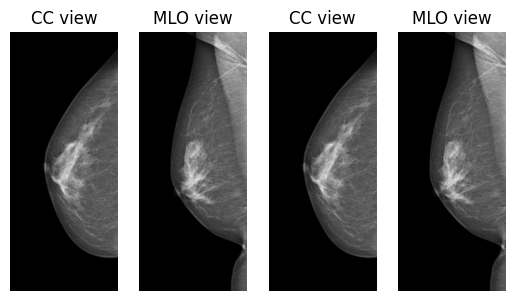

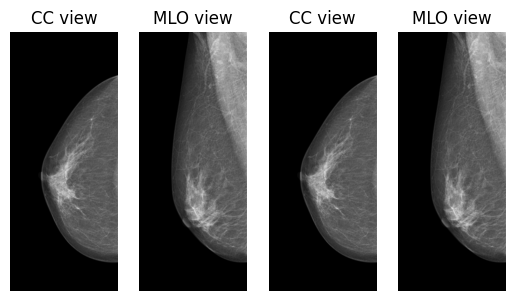

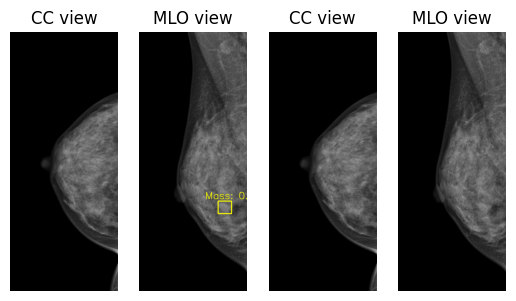

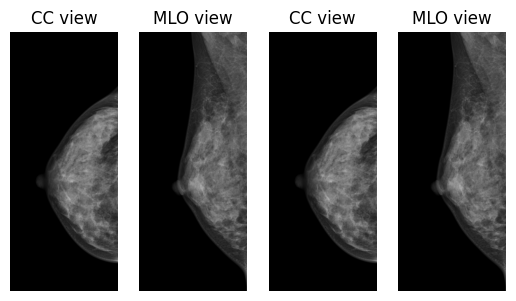

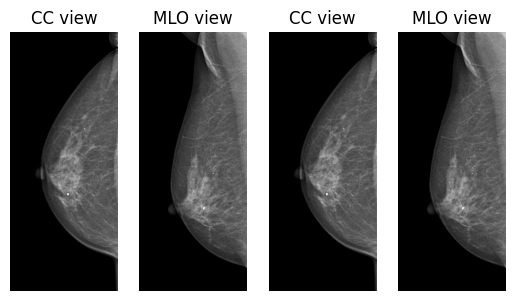

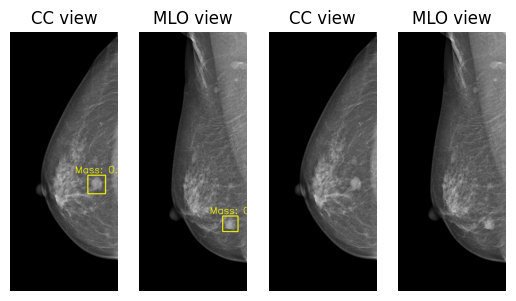

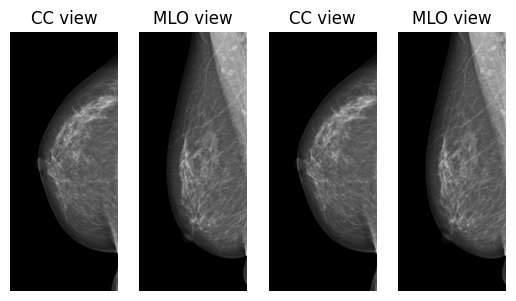

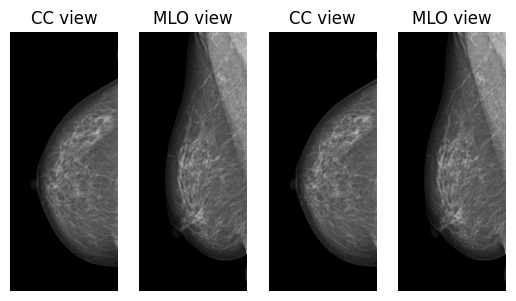

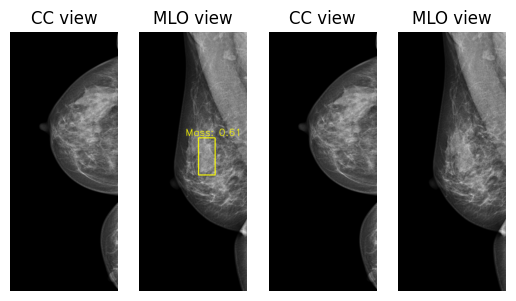

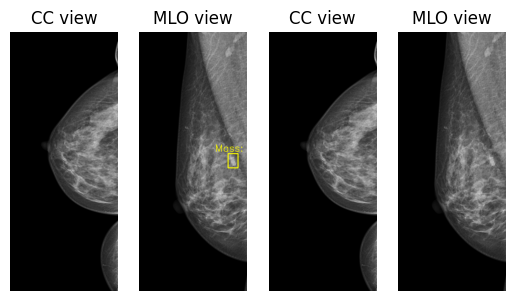

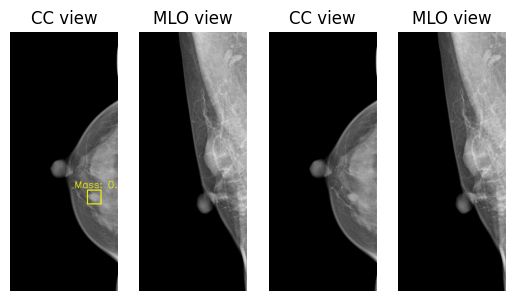

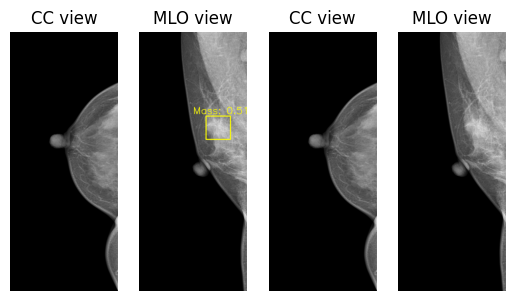

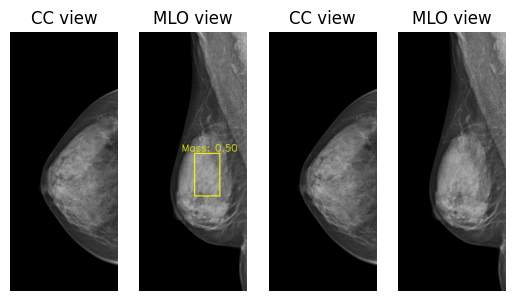

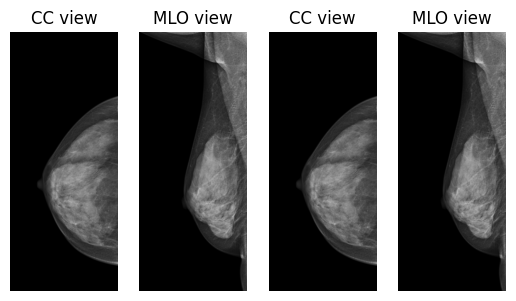

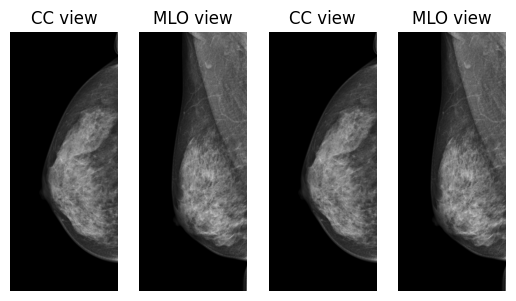

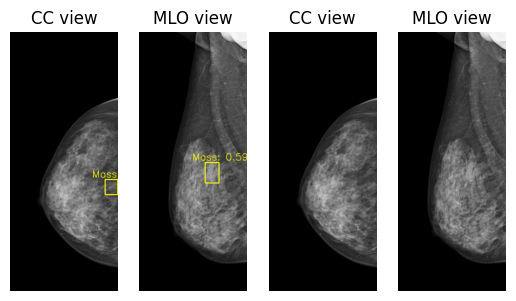

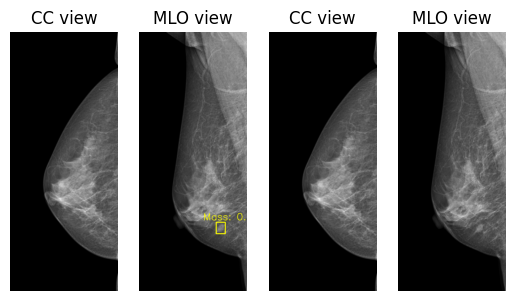

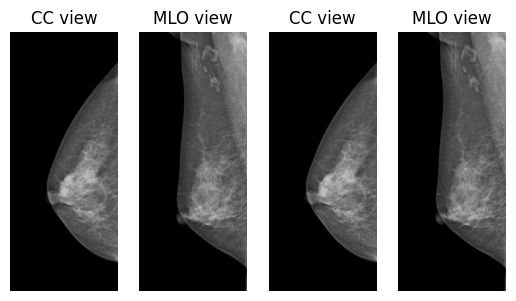

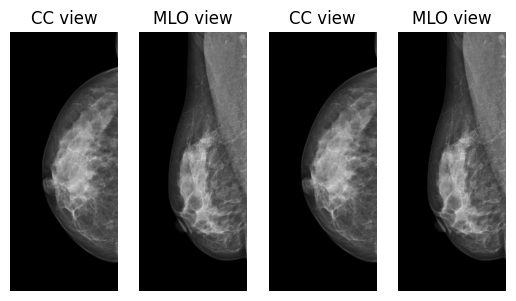

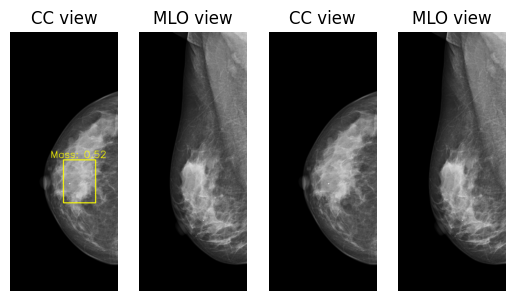

In [6]:
num_img = 20
save_dir = '/home/vishc1/hoang/fasterrcnn-pytorch-training-pipeline/mammo_viz_img/'
for idx, (images_CC, images_MLO, targets_CC, targets_MLO) in enumerate(itertools.islice(valid_loader, num_img)):
    images_CC = list(image_CC.to(device) for image_CC in images_CC)
    images_MLO = list(image_MLO.to(device) for image_MLO in images_MLO)
    targets_CC = [{k: v.to(device) for k, v in t.items()} for t in targets_CC]
    targets_MLO = [{k: v.to(device) for k, v in t.items()} for t in targets_MLO]
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    model_time = time.time()
    with torch.no_grad():
        outputs_CC, outputs_MLO= model(images_CC, images_MLO, targets_CC, targets_MLO)
    
    for i in range(len(images_CC)):
        true_dict_CC, preds_dict_CC = dict(), dict()
        true_dict_MLO, preds_dict_MLO = dict(), dict()
        true_dict_CC['boxes'] = targets_CC[i]['boxes'].detach().cpu()
        true_dict_CC['labels'] = targets_CC[i]['labels'].detach().cpu()
        preds_dict_CC['boxes'] = outputs_CC[i]['boxes'].detach().cpu()
        preds_dict_CC['scores'] = outputs_CC[i]['scores'].detach().cpu()
        preds_dict_CC['labels'] = outputs_CC[i]['labels'].detach().cpu()
                
        true_dict_MLO['boxes'] = targets_MLO[i]['boxes'].detach().cpu()
        true_dict_MLO['labels'] = targets_MLO[i]['labels'].detach().cpu()
        preds_dict_MLO['boxes'] = outputs_MLO[i]['boxes'].detach().cpu()
        preds_dict_MLO['scores'] = outputs_MLO[i]['scores'].detach().cpu()
        preds_dict_MLO['labels'] = outputs_MLO[i]['labels'].detach().cpu()
        
        img_CC = images_CC[i].permute(1, 2, 0).cpu().numpy().copy()
        img_MLO = images_MLO[i].permute(1, 2, 0).cpu().numpy().copy()
        img_CC1 = img_CC.copy()
        img_MLO1 = img_MLO.copy()
        
        for j, label in enumerate(preds_dict_CC['labels']):
            if  label == 1:
                x_min, y_min, x_max, y_max = preds_dict_CC['boxes'][j]
                img_CC =cv2.rectangle(img=img_CC,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,1.0,0),thickness = 3)
                score= preds_dict_CC['scores'][j]
                img_CC= cv2.putText(img_CC, f'Mass: {score:.2f}', (int(x_min)-60,int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (1.0,1.0,0), 2)
            
        for j, label in enumerate(preds_dict_MLO['labels']):
            if  label ==1:
                x_min, y_min, x_max, y_max = preds_dict_MLO['boxes'][j]
                img_MLO =cv2.rectangle(img=img_MLO,pt1= (int(x_min),int(y_min)),pt2= (int(x_max),int(y_max)), color = (1.0,1.0,0),thickness = 3)
                score= preds_dict_MLO['scores'][j]
                img_MLO= cv2.putText(img_MLO, f'Mass: {score:.2f}', (int(x_min)-60 ,int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (1.0,1.0,0), 2)
            
        fig, axs= plt.subplots(1,4)
        axs[0].imshow(img_CC)
        axs[0].axis('off')
        axs[0].set_title("CC view")
        axs[1].imshow(img_MLO)
        axs[1].axis('off')
        axs[1].set_title("MLO view")
        axs[2].imshow(img_CC1)
        axs[2].axis('off')
        axs[2].set_title("CC view")
        axs[3].imshow(img_MLO1)
        axs[3].set_title("MLO view")
        axs[3].axis('off')
        save_path = os.path.join(save_dir, f'{idx}_{i}.png')
        plt.savefig(save_path, dpi=1200, format='svg', bbox_inches='tight')
        plt.show()
        